<a href="https://colab.research.google.com/github/amimulhasan/Deep-Learning/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download bilalakgz/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/bilalakgz/brain-tumor-mri-dataset
License(s): MIT
  0% 0.00/92.1M [00:00<?, ?B/s]
100% 92.1M/92.1M [00:00<00:00, 1.26GB/s]


In [4]:
import zipfile

zip_path = '/content/brain-tumor-mri-dataset.zip'
extract_to = 'brain_tumor_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipping completed!")

Unzipping completed!


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.43MB/s]


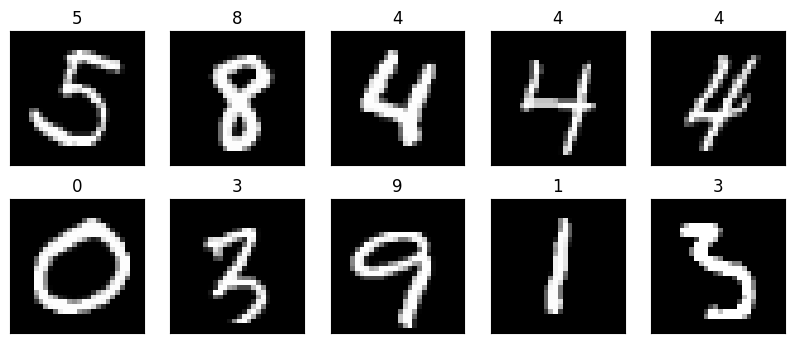

Starting training...


Epoch 1/15: 100%|██████████| 750/750 [01:19<00:00,  9.38it/s, loss=0.165, acc=96.2]


New best model saved with val_loss: 0.0529
Epoch 1: Train Loss: 0.1655, Acc: 96.16% | Val Loss: 0.0529, Acc: 98.43%


Epoch 2/15: 100%|██████████| 750/750 [01:19<00:00,  9.43it/s, loss=0.0654, acc=98.2]


New best model saved with val_loss: 0.0387
Epoch 2: Train Loss: 0.0654, Acc: 98.21% | Val Loss: 0.0387, Acc: 98.77%


Epoch 3/15: 100%|██████████| 750/750 [01:19<00:00,  9.44it/s, loss=0.048, acc=98.5]


New best model saved with val_loss: 0.0334
Epoch 3: Train Loss: 0.0480, Acc: 98.54% | Val Loss: 0.0334, Acc: 98.92%


Epoch 4/15: 100%|██████████| 750/750 [01:19<00:00,  9.49it/s, loss=0.0379, acc=98.8]


New best model saved with val_loss: 0.0319
Epoch 4: Train Loss: 0.0379, Acc: 98.82% | Val Loss: 0.0319, Acc: 99.01%


Epoch 5/15: 100%|██████████| 750/750 [01:19<00:00,  9.49it/s, loss=0.0329, acc=99]


New best model saved with val_loss: 0.0314
Epoch 5: Train Loss: 0.0329, Acc: 99.00% | Val Loss: 0.0314, Acc: 99.05%


Epoch 6/15: 100%|██████████| 750/750 [01:18<00:00,  9.50it/s, loss=0.0278, acc=99.2]


New best model saved with val_loss: 0.0293
Epoch 6: Train Loss: 0.0278, Acc: 99.17% | Val Loss: 0.0293, Acc: 99.12%


Epoch 7/15:  83%|████████▎ | 619/750 [01:05<00:13,  9.39it/s, loss=0.0245, acc=99.2]


KeyboardInterrupt: 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
from torch.utils.tensorboard import SummaryWriter

# A. Configuration Setup
class Config:
    def __init__(self):
        self.seed = 42
        self.batch_size = 64
        self.learning_rate = 0.001
        self.num_epochs = 15
        self.num_classes = 10
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.data_dir = '/content/brain_tumor_data'
        self.log_dir = './logs'
        self.model_save_path = './model.pth'

config = Config()

# B. Set Random Seeds for Reproducibility
torch.manual_seed(config.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.seed)

# C. Data Preparation
def prepare_data():
    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load datasets
    train_dataset = datasets.MNIST(
        root=config.data_dir,
        train=True,
        transform=transform,
        download=True
    )

    test_dataset = datasets.MNIST(
        root=config.data_dir,
        train=False,
        transform=transform
    )

    # Split train into train and validation
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=config.batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=config.batch_size,
        shuffle=False
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=config.batch_size,
        shuffle=False
    )

    return train_loader, val_loader, test_loader

# D. Model Architecture
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# E. Model Initialization
def initialize_model():
    model = CNN(num_classes=config.num_classes).to(config.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    return model, criterion, optimizer, scheduler

# F. Training Function
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader):
    writer = SummaryWriter(config.log_dir)
    best_val_loss = float('inf')

    for epoch in range(config.num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.num_epochs}')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(config.device), labels.to(config.device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix({
                'loss': train_loss/(total/config.batch_size),
                'acc': 100.*correct/total
            })

        train_loss = train_loss/len(train_loader)
        train_acc = 100.*correct/total

        # Validation phase
        val_loss, val_acc = evaluate_model(model, criterion, val_loader)
        scheduler.step(val_loss)

        # Log metrics
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), config.model_save_path)
            print(f"New best model saved with val_loss: {val_loss:.4f}")

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')

    writer.close()
    return model

# G. Evaluation Function
def evaluate_model(model, criterion, data_loader):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(config.device), labels.to(config.device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = loss/len(data_loader)
    accuracy = 100.*correct/total
    return avg_loss, accuracy

# H. Visualization Functions
def plot_sample_images(loader):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    fig = plt.figure(figsize=(10, 4))
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
        img = images[idx].numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(str(labels[idx].item()))
    plt.show()

def plot_metrics(log_dir):
    # This would typically be done in TensorBoard
    print("Run 'tensorboard --logdir={}' to view metrics".format(log_dir))

# I. Main Execution
def main():
    # Prepare data
    train_loader, val_loader, test_loader = prepare_data()

    # Visualize sample images
    plot_sample_images(train_loader)

    # Initialize model
    model, criterion, optimizer, scheduler = initialize_model()

    # Train model
    print("Starting training...")
    model = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)

    # Load best model
    model.load_state_dict(torch.load(config.model_save_path))

    # Final evaluation
    print("Evaluating on test set...")
    test_loss, test_acc = evaluate_model(model, criterion, test_loader)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    # Visualize metrics
    plot_metrics(config.log_dir)

if __name__ == '__main__':
    # Create directories if they don't exist
    os.makedirs(config.data_dir, exist_ok=True)
    os.makedirs(config.log_dir, exist_ok=True)

    main()